In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
# import timeit
from scipy.integrate import odeint
from scipy import stats
from EDMtoolkit import *
from modelSystems import *
import datetime

plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2

In [2]:
settlingTime = 2 ** 9
tlen = 2 ** 8
end = 2 ** 6 # 2**5 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0

tr = np.linspace(0, end, num=tlen)
t = tr / end

In [3]:
## Drivers ##

# r = lambda t: 4 # - t / tlen
# b1 = lambda t: 3 + 5 * t / end
# rho = lambda t : 28 # + 10 * t / end
# sigma = lambda t : 10 # + 10 * t / end
# beta = lambda t : 5.0 / 3.0 + 3*t/end
# F = lambda t : 5 + 15 * t / end
# N = 5

In [5]:
## Time Series Generation ##

# x0 = rand.rand(1)
# Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)

x0 = rand.random(N)
# x0 = np.array([1,0.5,7]) - rand.random(3) * 0.1

Xr = generateTimeSeriesContinuous("Lorenz96P", x0, nsargs=(F, N), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,N-1,None]
# Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime)[:,0,None]
# Xr = generateTimeSeriesContinuous('LorenzP', np.array([1,5,17]), nsargs=(rho, sigma, beta), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,0,None]

## Add Noise ##
noise_magnitude = 0.0
Xr += rand.random((Xr.shape[0],1)) * np.ptp(Xr) * noise_magnitude

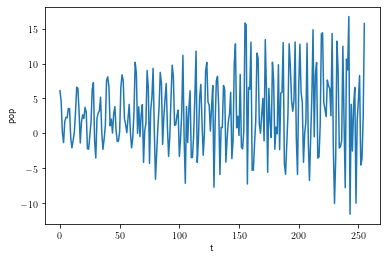

In [6]:
plotTS(Xr)

In [7]:
r_sqrd_M = np.var(Xr) / (np.var(Xr) +  (noise_magnitude*np.ptp(Xr))**2/12)

In [8]:
r_sqrd_M

1.0

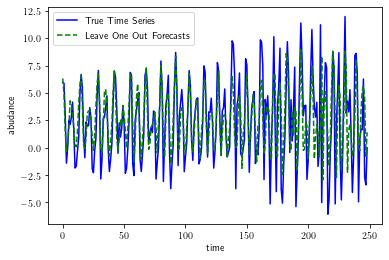

In [19]:
delta_agg, r_sqrd_EDM, ns_area = get_delta_agg(Xr, 6, return_forecast_skill=True)

In [20]:
delta_agg

1.2159611266729549

In [21]:
r_sqrd_EDM

0.5051401256494988

In [11]:
horizon = 1
num_repetitions = 100
noise_magnitude = 0.0
maxLags = 6

table = np.zeros((num_repetitions, 6), dtype=np.longdouble)

for i in range(num_repetitions):
    if table[i, 2] != 0:
        continue
    
    # noise_magnitude = rand.random(1)[0] * 0.5
    rate = rand.random(1)[0]
    
    F = lambda t : 5 + rate * 15 * t / end
    # b1 = lambda t: 3 + rate * 5 * t / end
    
    x0 = np.multiply(np.array([1,0.5,7]),rand.random(3))
    x0 = rand.random(N)
    
    #Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime)[:,0,None]
    Xr = generateTimeSeriesContinuous("Lorenz96P", x0, nsargs=(F, N), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,N-1,None]
    
    r_sqrd_M = np.var(Xr) / (np.var(Xr) +  (noise_magnitude*np.ptp(Xr))**2/12)
    Xr += noise_magnitude * np.ptp(Xr) * (rand.random((Xr.shape[0],1))-0.5) 

    # plotTS(Xr)

    delta_agg, r_sqrd, ns_area = get_delta_agg(Xr, maxLags, return_forecast_skill=True)
    table[i] = np.array([rate, delta_agg, noise_magnitude, r_sqrd, r_sqrd_M, ns_area])
    
    # print(f"rate = {:.3f}, delta = {:.3f}, alpha={:.3f}, r^2_E = {:.3f}$, $r^2_M={:.3f}$, NS Area = {:.3f}".format(rate,delta_agg,noise_magnitude,r_sqrd,r_sqrd_M,ns_area))
    print(f"rate = {rate:.3f}, delta = {delta_agg:.3f}, r^2_E = {r_sqrd:.3f}, r^2_M={r_sqrd_M:.3f}")
    

KeyboardInterrupt: 

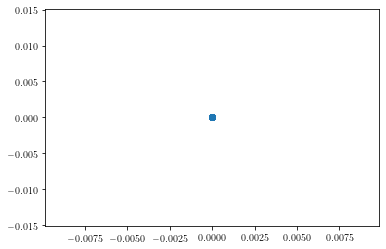

In [12]:
plt.scatter(table[:,0],table[:,5])

Text(0.5, 1.0, 'Are we overfitting?(Hastings Powell, len=256, $\\alpha\\in[0,0.5]$)')

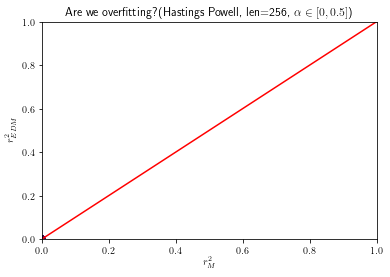

In [13]:
plt.scatter(table[:,4], table[:,3],c=table[:,2])
plt.plot(np.linspace(0,1,num=2),np.linspace(0,1,num=2), color="red")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel(r"$r^2_{M}$")
plt.ylabel(r"$r^2_{EDM}$")
plt.title(r"Are we overfitting?(Hastings Powell, len=256, $\alpha\in[0,0.5]$)")

In [14]:
table2 = table.copy()

In [16]:
"""
horizon = 1
num_repetitions = 100
noise_magnitude = 0.0
maxLags = 6

table = np.zeros((num_repetitions, 2), dtype=np.longdouble)

for i in range(num_repetitions):
    rate = rand.random(1)[0]
    print(f"Rate = {rate}")

    r = lambda t: 4 - rate * t / tlen
    
    x0 = rand.rand(1)
    Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)

    Xr += noise_magnitude * np.ptp(Xr) * (rand.random((Xr.shape[0],1))-0.5) 

    plotTS(Xr)

    delta_agg = get_delta_agg(Xr, t, maxLags)

    table[res*num_repetitions+i] = np.array([rate, delta_agg])
"""

'\nhorizon = 1\nnum_repetitions = 100\nnoise_magnitude = 0.0\nmaxLags = 6\n\ntable = np.zeros((num_repetitions, 2), dtype=np.longdouble)\n\nfor i in range(num_repetitions):\n    rate = rand.random(1)[0]\n    print(f"Rate = {rate}")\n\n    r = lambda t: 4 - rate * t / tlen\n    \n    x0 = rand.rand(1)\n    Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)\n\n    Xr += noise_magnitude * np.ptp(Xr) * (rand.random((Xr.shape[0],1))-0.5) \n\n    plotTS(Xr)\n\n    delta_agg = get_delta_agg(Xr, t, maxLags)\n\n    table[res*num_repetitions+i] = np.array([rate, delta_agg])\n'

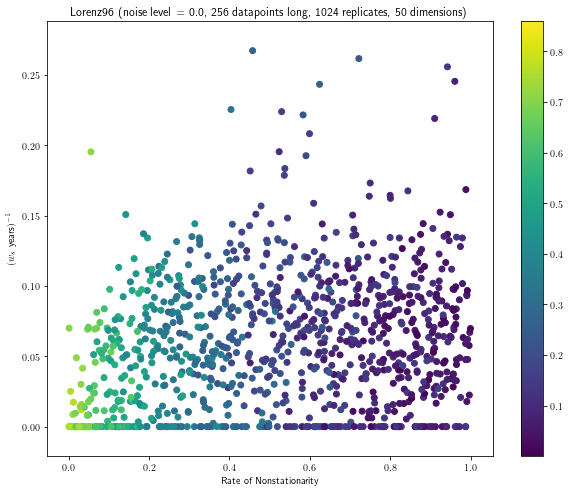

In [18]:
length = 256
noise_level = "00"

# filename = f"hastings_powell_{length}_0-{noise_level}_noise.csv"
# filename = f"hastings_powell_{length}_0-{noise_level}_nsarea.csv"
filename = f"logistic_map_{length}_0-{noise_level}_noise.csv"
filename = "lorenz96_256_0-00_50_dimensions.csv"
# filename = "lorenz96_256_0-00_5_dimensions.csv"

table = np.loadtxt(filename, delimiter=",")

# w_s_inv = table[:,3]
w_s_inv = np.sqrt(table[:,1]) / 16 # table[:,0]
# w_s_inv = 16 / np.sqrt(table[:,1])
# w_s_inv = table[:,1]

large_delta_filter = w_s_inv == w_s_inv

fig, ax = plt.subplots(1,figsize=(10,8))
r_sqrd = np.corrcoef(table[large_delta_filter,0],w_s_inv)[0,1]**2

scat = ax.scatter(table[large_delta_filter,0], w_s_inv[large_delta_filter], label=r"$r^2={r:.3f}$".format(r=r_sqrd), c=table[large_delta_filter,2])

ax.set_xlabel("Rate of Nonstationarity")
ax.set_ylabel(r"$(w_s$ years$)^{-1}$")
# ax.set_ylabel(r"sum ln L")
# ax.legend()
# ax.set_ylim([0,48])
# ax.set_title(r"Logistic Map (noise level = 0.0, 256 datapoints long, 1024 replicates)")
ax.set_title(r"Lorenz96 (noise level = 0.0, 256 datapoints long, 1024 replicates, 50 dimensions)")
# ax.set_title(r"Logistic Map (noise level = 0.0, 256 datapoints long, 1024 replicates)")
plt.colorbar(scat)
plt.show()

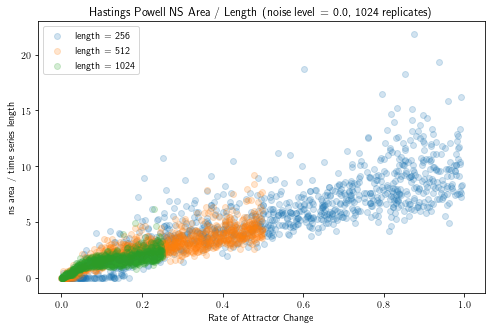

In [493]:
lengths = [256,512,1024]
noise_level = "00"

fig, ax = plt.subplots(1,figsize=(8,5))

for length in lengths:
    #filename = f"hastings_powell_{length}_0-{noise_level}_noise.csv"
    filename = f"hastings_powell_{length}_0-{noise_level}_nsarea.csv"

    table = np.loadtxt(filename, delimiter=",")

    w_s_inv = table[:,1] / (length  / lengths[0])** 2

    r_sqrd = np.corrcoef(table[large_delta_filter,0],w_s_inv)[0,1]**2

    # scat = ax.scatter(table[large_delta_filter,0], w_s_inv[large_delta_filter], label=r"$r^2={r:.3f}$".format(r=r_sqrd), c=table[large_delta_filter,2])
    # scat = ax.scatter(table[large_delta_filter,0], w_s_inv[large_delta_filter], label="length = {}".format(length), alpha=0.2)
    scat = ax.scatter(table[large_delta_filter,0]/ (length / lengths[0]), w_s_inv[large_delta_filter], label="length = {}".format(length), alpha=0.2)
    ax.set_xlabel("Rate of Attractor Change")
    ax.set_ylabel("ns area / time series length")
    # ax.set_ylabel(r"sum ln L")
    ax.legend()
    #ax.set_ylim([0,50])
    ax.set_title(r"Hastings Powell NS Area / Length (noise level = 0.0, 1024 replicates)")
    #plt.colorbar(scat)
plt.show()

In [425]:
table


array([[6.96366686e-01, 1.57914399e+01, 9.57277829e-01, 4.88332284e+02],
       [4.71374795e-01, 1.26207394e+01, 9.58836495e-01, 2.57302162e+02],
       [1.68631466e-01, 4.51674153e+00, 9.78688076e-01, 1.30396519e+02],
       ...,
       [5.93983195e-01, 9.72618215e+00, 9.49816084e-01, 4.02199730e+02],
       [7.64394439e-01, 1.57785729e+01, 9.58204023e-01, 3.96969449e+02],
       [9.86298077e-01, 2.99071177e+01, 9.64891268e-01, 4.95743997e+02]])

In [271]:
min(table[:,2])

0.47357238194229817

In [232]:
table[:,0]

array([  11.,   20.,   25., ..., 1004.,  648.,  991.])

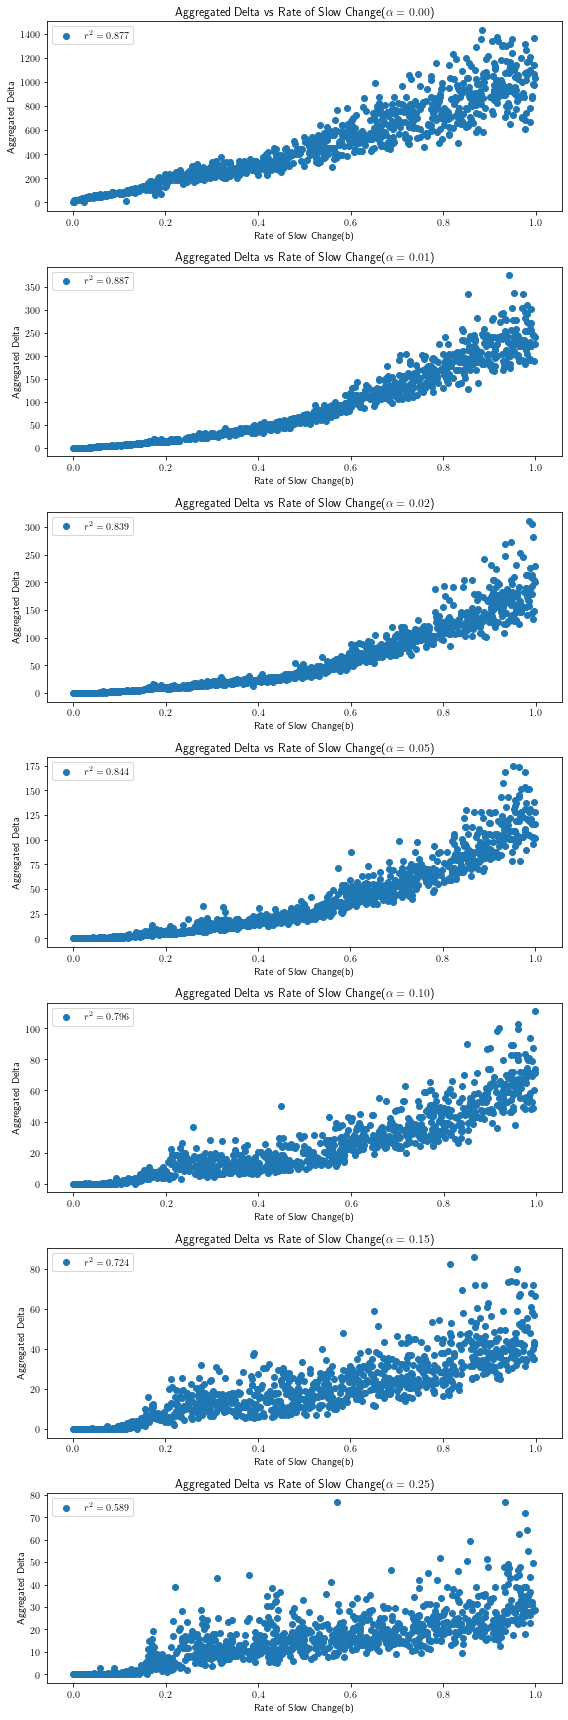

In [54]:
noise_levels = ["00","01","02","05","10","15","25"]

r_sqrd_noise = np.zeros(len(noise_levels))
fig, ax = plt.subplots(7, figsize=(8,24))

for i, noise_level in enumerate(noise_levels):
    filename = f"logistic_map_1024_0-{noise_level}_noise.csv"
    
    table = np.loadtxt(filename, delimiter=",")
    
    r_sqrd_noise[i] = np.corrcoef(table[:,0], table[:,1])[0,1] ** 2
    
    ax[i].scatter(table[:,0],table[:,1],label=r"$r^2={:.3f}$".format(r_sqrd_noise[i]))
    ax[i].set_xlabel("Rate of Slow Change(b)")
    ax[i].set_ylabel("Aggregated Delta")
    ax[i].legend()
    ax[i].set_title(r"Aggregated Delta vs Rate of Slow Change($\alpha=0.{}$)".format(noise_levels[i]))
    
plt.tight_layout()
plt.show()

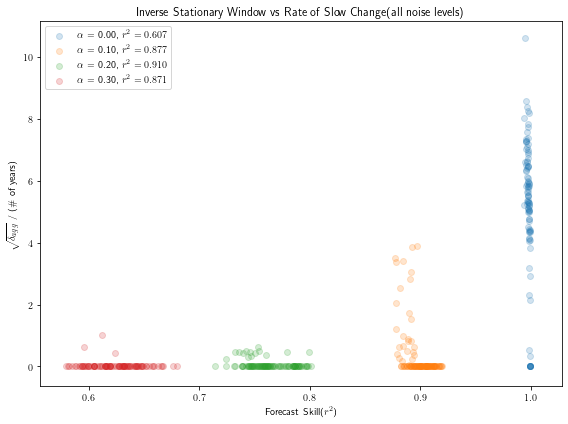

In [355]:
# time_series_length = [128,256,512,1024]
time_series_noise = ["00","10","20","30"]
# time_series_noise = ["00","01","02","05","10","15","25"]


# r_sqrd_len = np.zeros(len(time_series_length))
r_sqrd_len = np.zeros(len(time_series_noise))
# fig, ax = plt.subplots(len(time_series_length), figsize=(8,24))
fig, ax = plt.subplots(1, figsize=(8,6))

X = np.ones((len(time_series_noise)*1024,2))
Y = np.ones(len(time_series_noise)*1024)

# for i,l in enumerate(time_series_length):
for i,l in enumerate(time_series_noise):
    # filename = f"logistic_map_1024_0-{l}_noise.csv"
    filename = f"hastings_powell_1024_0-{l}_noise.csv"
    
    table = np.loadtxt(filename, delimiter=",")
    r_sqrd_len[i] = np.corrcoef(table[:,0], table[:,1])[0,1] ** 2
    
    """
    ax[i].scatter(table[:,0],table[:,1],label=r"$r^2={:.3f}$".format(r_sqrd_len[i]))
    ax[i].set_xlabel("Rate of Slow Change(b)")
    ax[i].set_ylabel("Aggregated Delta")
    ax[i].legend()
    ax[i].set_title(r"Aggregated Delta vs Rate of Slow Change(length = {})".format(time_series_length[i]))
    """
    
    valid_series = table[:,0] < 0.1
    # valid_entries = table[:,1] == table[:,1]
    
    n_years = 1024
    noise_level = int(l) / 30
    stationary_windows = 10000*np.sqrt(table[valid_series,1]) / ( 12 ** 0.5 * n_years) # - np.log(noise_level)
    
    # ax.scatter(table[:,0], stationary_windows, label=r"$\alpha$ = 0.{}, $r^2={:.3f}$".format(time_series_noise[i],r_sqrd_len[i]), alpha=0.2)
    ax.scatter(table[valid_series,2], stationary_windows, label=r"$\alpha$ = 0.{}, $r^2={:.3f}$".format(time_series_noise[i],r_sqrd_len[i]), alpha=0.2)
    # ax.set_xlabel("Rate of Slow Change(b)")
    #noise_levels = np.ones(len(table[:,2])) * int(l)/100
    
    #ax.scatter(table[:,2], noise_levels, alpha=0.006)
    
    #X[1024*i:1024*(i+1),0] = table[:,2]
    #Y[1024*i:1024*(i+1)] = noise_levels
    
    ax.set_xlabel(r"Forecast Skill($r^2$)")
    # ax.set_ylabel(r"Noise Level($\alpha$)")
    
    # ax.set_xlabel(r"Nonstationarity Rate(b)")
    ax.set_ylabel(r"$\sqrt{\delta_{agg}}$ / (\# of years) ")
    ax.legend()
    # ax.set_ylim([0,0.005])
    # ax.set_title(r"Aggregated Delta vs Rate of Slow Change(length = {})".format(time_series_length[i]))
    ax.set_title(r"Inverse Stationary Window vs Rate of Slow Change(all noise levels)")
    
plt.tight_layout()
plt.show()

In [324]:
m, c = la.lstsq(X, Y)[0]

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [328]:
np.corrcoef(X[:,0], Y)[0,1] ** 2

0.962170581043006

In [325]:
m

-0.6280720758111213

In [326]:
c

0.6274768633532436

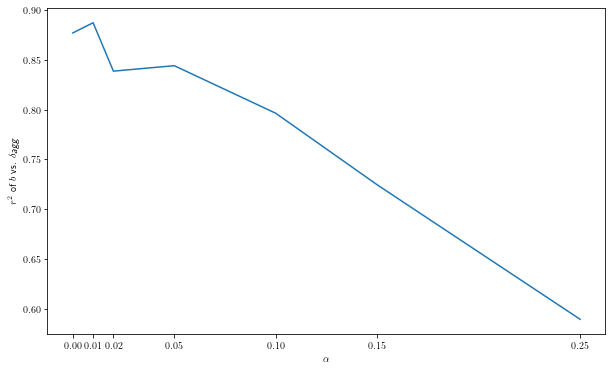

In [55]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot([0.0,0.01,0.02,0.05,0.1,0.15,0.25], r_sqrd_noise)
ax.set_xticks([0.0,0.01,0.02,0.05,0.1,0.15,0.25])
ax.set_ylabel(r"$r^2$ of $b$ vs. $\delta_\textit{agg}$")
ax.set_xlabel(r"$\alpha$")

plt.show()

In [121]:
tank_top_drop_top = rand.random((30,30))

In [125]:
np.hstack((np.array([53]),tank_top_drop_top[:,2],tank_top_drop_top[:,20]))

array([53.        ,  0.65826348,  0.676643  ,  0.90010526,  0.44078428,
        0.67168734,  0.13422667,  0.50020896,  0.19356026,  0.97293582,
        0.65463009,  0.14041727,  0.17662616,  0.89468766,  0.6834506 ,
        0.86515492,  0.34078279,  0.68685976,  0.26764976,  0.92764747,
        0.98109815,  0.76934347,  0.36082093,  0.7978613 ,  0.47890895,
        0.5872863 ,  0.45355113,  0.88673499,  0.49972099,  0.50610577,
        0.17408796,  0.14175122,  0.20773056,  0.82414953,  0.48117022,
        0.46112326,  0.79499942,  0.35996085,  0.36826984,  0.87849756,
        0.12310646,  0.2937621 ,  0.22619134,  0.6590714 ,  0.05851144,
        0.22761323,  0.38549379,  0.60669475,  0.11333768,  0.26053129,
        0.70818632,  0.76038527,  0.05454897,  0.90510218,  0.62612159,
        0.80932407,  0.40984254,  0.95007972,  0.08081638,  0.77367617,
        0.76795724])

In [79]:
table.shape

(100, 31)

In [80]:
table[20:,1:11]

array([[5.09875000e-01, 3.76269187e+00, 2.33966425e+00, 1.33974301e-01,
        3.24038621e-01, 2.64682619e+00, 2.17575825e+00, 1.71678788e+00,
        2.17387500e+00, 3.53241630e+00],
       [0.00000000e+00, 5.06332740e+00, 4.48031820e+00, 4.55425525e+00,
        3.04533591e+00, 2.81078875e+00, 2.59903185e+00, 1.85814819e+00,
        2.43974301e+00, 3.08675799e+00],
       [1.07706250e+00, 5.83284921e+00, 6.57819488e+00, 3.95280755e+00,
        3.55984311e+00, 3.53701563e+00, 3.10069719e+00, 3.02493625e+00,
        3.98048819e+00, 3.91594301e+00],
       [0.00000000e+00, 6.64515019e+00, 4.99071719e+00, 1.68805304e+00,
        2.32026950e+00, 2.58380750e+00, 6.84290581e-01, 8.00327827e-01,
        1.30554875e+00, 2.51868719e+00],
       [1.72758875e+00, 4.94919623e+00, 4.54947936e+00, 3.70317850e+00,
        3.41917009e+00, 3.66115425e+00, 3.10069719e+00, 2.60152311e+00,
        1.78751782e+00, 2.51568433e+00],
       [1.07342305e+00, 5.71105439e+00, 7.70104081e+00, 7.79234666e+00,
   

In [81]:
fig, ax = plt.subplots(1,3,fisize=(16,8))

ax[0].plot(table[0], )
ax[0].set_ylabel("Nonstationarity Area")
ax[0].set_xlabel("Nonstationarity Rate")


ax[0].plot(table[0], )
ax[0].set_ylabel("Delta Sum")
ax[0].set_xlabel("Nonstationarity Rate")


ax[0].plot(table[0], np.exp(table[:,11:21] - table[:,21:]) * table[])
ax[0].set_ylabel("Aggregated Delta")
ax[0].set_xlabel("Nonstationarity Rate")

SyntaxError: invalid syntax (<ipython-input-81-2f64dd6561b3>, line 13)

In [82]:
if np.sum(T2[:,4]) == 0:
    delta_agg = 0
else:
    delta_agg = np.average(T2[:,0] - T2[:,1], weights=T2[:,4])

In [83]:
# but first, save the data

datetime_str = datetime.datetime.now().strftime("%m-%d-%Y") 
np.save(f"nonstationarity_rate_vs_delta_and_log_likelihood_NS_S_{datetime_str}", table)

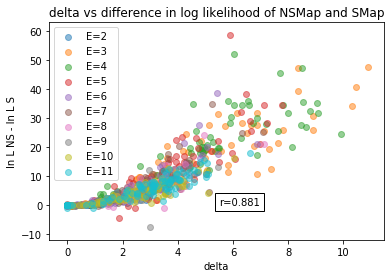

In [84]:
# First question: is delta correlated with the log likelihood difference?

deltas = table[:,1:11]
nonstationarity_areas = (table[:,11:21] - table[:,21:])

fig, ax = plt.subplots(1)

ax.set_title("delta vs difference in log likelihood of NSMap and SMap")
ax.set_xlabel("delta")
ax.set_ylabel("ln L NS - ln L S")
for E in range(2,2+maxLags):
    ax.scatter(deltas[:,E-2], nonstationarity_areas[:,E-2], alpha=0.5, label=f"E={E}")
ax.text(5.5,0,f"r={np.corrcoef(deltas.flatten(),nonstationarity_areas.flatten())[1,0]:.3f}",bbox=dict(facecolor="white"))
ax.legend()
plt.show()

ValueError: x and y must be the same size

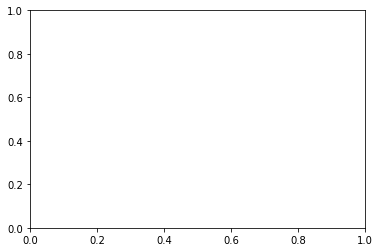

In [85]:
# I want to see if there is a relationship between E and the delta we optimze to
fig, ax = plt.subplots(1)

for E in range(2,2+maxLags):
    ax.scatter(np.ones(30)*E, deltas[:,E-2])

ax.set_ylabel("delta")
ax.set_xlabel("Embedding Dimension")
    
plt.show()

In [86]:
deltas.shape

(100, 10)

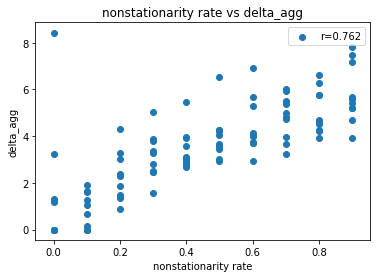

In [87]:
deltas = table[:,1:11]
weights = table[:,11:21] - table[:,21:]

deltas_agg = np.sum(deltas * weights, axis=1) * np.reciprocal(np.sum(weights,axis=1), where=np.sum(weights,axis=1)!=0)

fig, ax = plt.subplots(1)

ax.set_title("nonstationarity rate vs delta_agg")
ax.set_xlabel("nonstationarity rate")
ax.set_ylabel("delta_agg")
ax.scatter(table[:,0], deltas_agg, label=f"r={np.corrcoef(table[:,0],deltas_agg)[1,0]:.3f}")
ax.legend()
plt.show()

In [88]:
deltas_agg = np.sum(deltas * np.exp(weights), axis=1) / np.sum(np.exp(weights), axis=1)

In [91]:
deltas_kagg = np.add(np.zeros(100),np.sum(table[:,1:11] * weights, axis=1) / np.sum(weights, axis=1), where=(np.sum(weights, axis=1)!=0))

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [92]:
deltas_agg

array([ 3.25574386,  0.        ,  0.55152617,  0.23927941,  0.42919001,
        0.03086702,  1.48321534,  1.00263504,  2.04822232,  3.02652479,
        4.59141677,  2.54365763,  8.17259388,  3.60493613,  5.857222  ,
        4.56223371,  3.51618207,  6.66618155,  6.30996251,  5.48958201,
        3.74233655,  4.91507307,  6.57817981,  6.64479334,  4.54947936,
        7.70104213,  8.65768169, 10.88577341,  6.48748708,  8.47551259,
        1.0092244 ,  1.10746165,  8.47247495,  0.        ,  1.43070382,
        0.        ,  0.        ,  0.        ,  1.53772929,  1.33281482,
        1.08337273,  0.        ,  0.        ,  0.40085162,  2.70974714,
        2.62713105,  3.71684401,  2.60755282,  0.51387289,  5.08020035,
        3.14090496,  5.03322101,  1.69700304,  3.42001369,  2.48004255,
        6.25835368,  5.0501038 ,  3.05930357,  4.3979771 ,  3.59783078,
        4.5960407 ,  3.29011315,  3.01549065,  2.8903402 ,  3.02948535,
        3.60163336,  4.61353722,  4.81632686,  4.81062434,  5.26

In [93]:
deltas_kagg

array([3.2564199 , 0.        , 1.33121401, 1.06570251, 0.68644704,
       0.15126165, 1.48020426, 1.34815291, 1.8620575 , 2.81616662,
       3.37818017, 2.46249753, 5.45046933, 3.00773742, 3.96314223,
       4.28222445, 2.95364332, 6.51787832, 5.6847623 , 5.29337582,
       2.95243838, 3.9712941 , 4.74112827, 5.00186871, 3.93832124,
       6.29664948, 5.7482384 , 7.81939726, 5.60965177, 7.17509517,
       1.19578125, 1.23149601, 8.43811995, 0.        , 1.27525449,
       0.        , 0.        , 0.        , 1.89391394, 1.59989542,
       1.63461668, 0.        , 0.        , 1.27148404, 2.34427421,
       2.36973792, 3.2902841 , 2.30510753, 0.88938946, 4.32302465,
       3.0359865 , 3.80886859, 1.56552887, 3.29996717, 2.51700452,
       5.02744027, 3.89743975, 2.45572359, 3.92358114, 3.1205641 ,
       3.59771459, 2.94985015, 2.72952701, 2.83373904, 2.67342098,
       3.02214726, 4.21960541, 3.65495134, 4.26369069, 4.06225982,
       3.46542466, 3.56603648, 4.02026569, 3.72663956, 3.72738

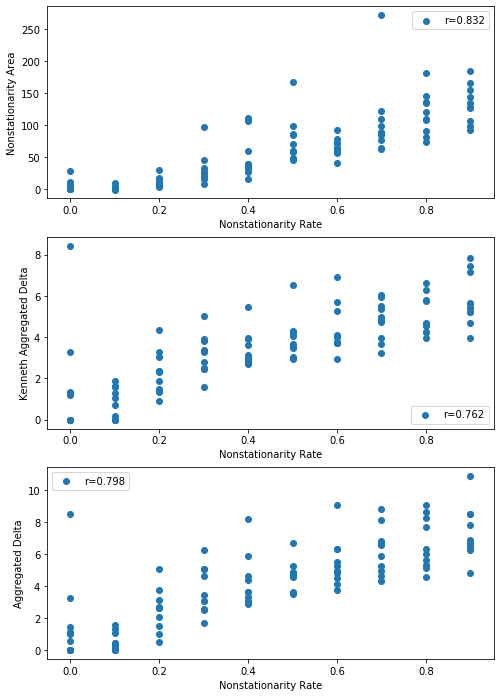

In [114]:
fig,ax = plt.subplots(3, figsize=(8,12))
ax[0].scatter(table[:,0], np.sum(table[:,11:21] - table[:,21:], axis=1),label=f"r={np.corrcoef(table[:,0], np.sum(table[:,11:21] - table[:,21:],axis=1))[0,1]:.3f}")
ax[0].set_xlabel("Nonstationarity Rate")
ax[0].set_ylabel("Nonstationarity Area")
ax[0].legend()
ax[1].scatter(table[:,0], deltas_kagg,label=f"r={np.corrcoef(table[:,0],deltas_kagg)[0,1]:.3f}")
ax[1].set_xlabel("Nonstationarity Rate")
ax[1].set_ylabel("Kenneth Aggregated Delta")
ax[1].legend()
ax[2].scatter(table[:,0], deltas_agg,label=f"r={np.corrcoef(table[:,0],deltas_agg)[0,1]:.3f}")
ax[2].set_xlabel("Nonstationarity Rate")
ax[2].set_ylabel("Aggregated Delta")
ax[2].legend()
plt.show()

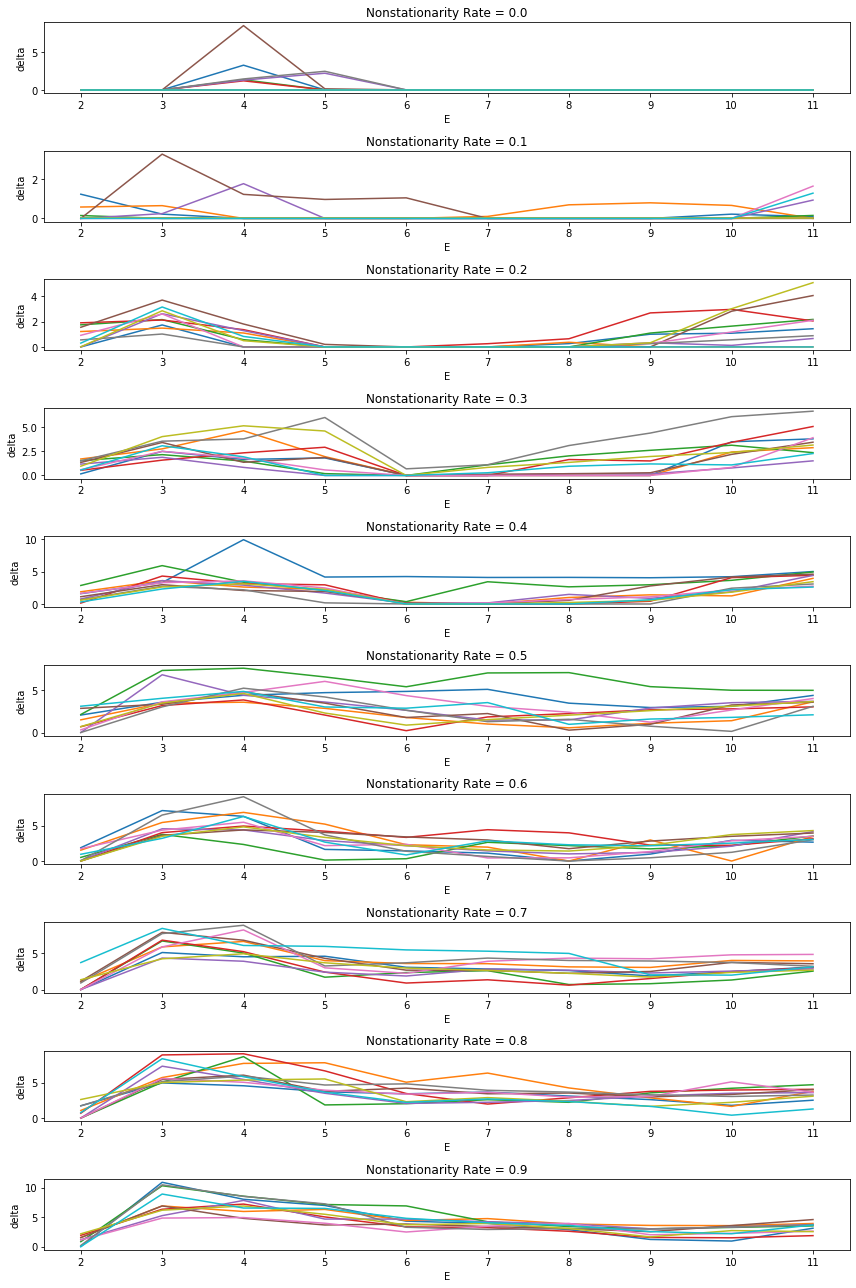

In [116]:
fig, ax = plt.subplots(resolution, figsize=(12,18))
for r in range(resolution):
    for i in range(table.shape[0]):
        if table[i,0] == r/resolution:
            ax[r].plot(range(2,2+resolution), table[i,1:11])
    ax[r].set_ylabel("delta")
    ax[r].set_xlabel("E")
    ax[r].set_xticks(range(2,2+resolution))
    ax[r].set_title(f"Nonstationarity Rate = {r/resolution}")
plt.tight_layout()
plt.show()

In [74]:
np.corrcoef(table[:,0],table[:,1])

array([[1.        , 0.13193826],
       [0.13193826, 1.        ]])

In [75]:
data = driverVdelta(25, thetaS, 2, 1)

NameError: name 'driverVdelta' is not defined

In [ ]:
weightDropoff = np.exp(-data[:,2]*0.25)
# weightDropoff = (1-datums[:,2])**(1/10)
pcc = np.corrcoef(data[:,0],weightDropoff)[0,1]

In [ ]:
# plotTS((1-datums[:,2])**0.1)
fig, ax = plt.subplots(1)
#ax.plot(datums[:,0], (1-datums[:,2])**0.1)

ax.plot(data[:,0], weightDropoff)
ax.set_ylabel("Drop in weight over 25% of series")
ax.set_xlabel("Rate of nonstationary change")
ax.text(0.65,0.98,f"r={pcc:.3f}")
plt.show()

In [ ]:
# plotTS((1-datums[:,2])**0.1)
fig, ax = plt.subplots(1)
#ax.plot(datums[:,0], (1-datums[:,2])**0.1)

ax.plot(data[:,0], data[:,2])
ax.set_ylabel("Optimal Delta")
ax.set_xlabel("Rate of nonstationary change")
ax.text(0.65,0.98,f"r={pcc:.3f}")
plt.show()

In [ ]:
# fix, ax = plt.subplots(1)
# ax.imshow(landNS[1:,1:,2])`

In [270]:
outlier_serieses = np.loadtxt("hastings_powell_outliers.csv", delimiter=",")

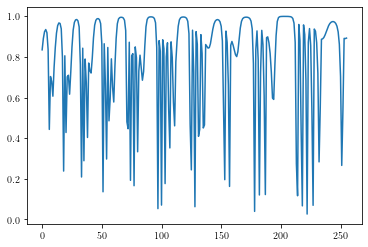

In [282]:
plt.plot(outlier_serieses[3,1:])

In [284]:
Xr = outlier_serieses[3,1:,None]

In [283]:
print(outlier_serieses[3,0])

20.442008697718045


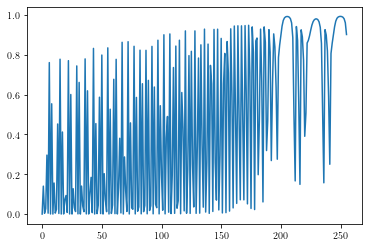

In [261]:
plt.plot(np.array([8.49496969e-04,1.40830231e-01,4.50945296e-03,2.77409915e-02,2.96581641e-01,5.28139514e-03,7.60612853e-01,1.32886476e-03,5.53981186e-01,8.15783707e-04,1.56536081e-01,5.64358139e-03,2.46504330e-02,4.52614172e-01,3.84096033e-03,7.77525384e-01,9.71697925e-04,4.12326364e-01,1.21424150e-03,7.27594239e-02,9.37848453e-02,8.86280760e-03,7.70255075e-01,1.45053923e-03,6.00468260e-01,8.74503952e-04,1.27892080e-01,3.11425339e-02,1.33603970e-02,7.43863054e-01,1.73259383e-03,6.61103962e-01,8.68950279e-04,1.41251744e-01,4.18070115e-02,1.27015423e-02,7.79112122e-01,1.51399797e-03,6.19021714e-01,1.08464894e-03,1.00765425e-01,1.84835034e-01,7.74746515e-03,8.31748159e-01,1.06520303e-03,4.54653745e-01,2.90904224e-03,4.51020540e-02,5.86880722e-01,3.27378624e-03,7.98441315e-01,9.07235190e-04,2.03429145e-01,7.33155393e-02,1.27915997e-02,8.34485016e-01,1.25712733e-03,5.26786455e-01,3.77338636e-03,4.62312327e-02,6.76809118e-01,2.77265708e-03,7.76900452e-01,1.24375593e-03,1.33892005e-01,3.80952215e-01,6.51638897e-03,8.62450803e-01,1.04243920e-03,2.87407362e-01,1.16365165e-01,1.38681957e-02,8.65363334e-01,1.23109039e-03,4.58133237e-01,3.12215305e-02,2.49378886e-02,8.42291971e-01,1.55812401e-03,5.85874591e-01,1.49358977e-02,3.67916819e-02,8.22839557e-01,1.86284797e-03,6.54567528e-01,1.27899677e-02,4.40247773e-02,8.22106242e-01,1.99622098e-03,6.71329663e-01,1.86894843e-02,4.24695297e-02,8.41853740e-01,1.91065513e-03,6.38037286e-01,5.02006161e-02,3.28002271e-02,8.72803769e-01,1.72476521e-03,5.44217268e-01,1.97380314e-01,2.01898305e-02,9.00052788e-01,1.74191176e-03,3.82805872e-01,4.90275815e-01,1.00655931e-02,9.04257694e-01,3.12642896e-03,1.95708708e-01,7.35795022e-01,4.42971212e-03,8.43452694e-01,3.00864388e-02,6.72916334e-02,8.72793255e-01,2.36952176e-03,6.10468098e-01,4.30181063e-01,1.66992157e-02,9.19553798e-01,4.92319354e-03,2.22738216e-01,7.95553268e-01,4.15570734e-03,8.17189980e-01,2.50771977e-01,3.64595714e-02,9.19522449e-01,4.38990191e-03,3.37615598e-01,7.83449211e-01,5.25401141e-03,8.49620976e-01,3.47213049e-01,3.54247963e-02,9.28410142e-01,1.09057845e-02,2.57930670e-01,8.53329999e-01,4.37109860e-03,7.46553511e-01,6.53837148e-01,1.39324789e-02,9.27013607e-01,2.61020776e-01,7.08079990e-02,9.28137555e-01,2.14525635e-02,2.93288709e-01,8.81817398e-01,6.40540612e-03,6.56585953e-01,8.06647729e-01,7.92708367e-03,8.65994792e-01,7.08188885e-01,1.56584608e-02,9.30018311e-01,6.02294194e-01,3.16868478e-02,9.44000828e-01,5.17670264e-01,5.42874087e-02,9.45102665e-01,4.83400591e-01,7.23733747e-02,9.44823681e-01,5.13300290e-01,7.19508339e-02,9.46199736e-01,5.98703498e-01,5.19402016e-02,9.47634220e-01,7.09288283e-01,2.89107024e-02,9.39533578e-01,8.10421405e-01,2.34173325e-02,8.69175058e-01,8.83785285e-01,1.98165487e-01,4.77391604e-01,9.28442539e-01,6.63317533e-01,6.16520738e-02,9.39583979e-01,8.61524417e-01,3.19346555e-01,4.67852543e-01,9.25637926e-01,8.12268104e-01,2.69093611e-01,6.49926979e-01,9.04539450e-01,8.38240487e-01,6.36018313e-01,2.75909823e-01,7.86452503e-01,8.49128458e-01,8.97012153e-01,9.43531557e-01,9.71784053e-01,9.84715470e-01,9.89984549e-01,9.91725855e-01,9.91319219e-01,9.88492760e-01,9.80833546e-01,9.59607072e-01,8.86332156e-01,4.89310111e-01,1.66962042e-01,9.41354693e-01,8.72239268e-01,5.52690212e-01,1.49721067e-01,9.24842786e-01,8.89594201e-01,7.73758883e-01,3.90838950e-01,5.08335028e-01,8.58715134e-01,8.71603771e-01,8.94282473e-01,9.22989553e-01,9.48504181e-01,9.65740147e-01,9.75271809e-01,9.79430314e-01,9.79657196e-01,9.75770673e-01,9.65009575e-01,9.37843980e-01,8.57351707e-01,5.21426285e-01,1.57553795e-01,9.25653600e-01,8.98838422e-01,8.19375882e-01,5.89211049e-01,2.50533969e-01,8.06262559e-01,8.57430344e-01,8.98219993e-01,9.40278877e-01,9.68468163e-01,9.82733512e-01,9.89116486e-01,9.91723493e-01,9.92309331e-01,9.91286812e-01,9.88047730e-01,9.80258907e-01,9.60576091e-01,9.01425406e-01]))